In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from numpy.random import randint
import math
from torch.nn import functional as F
import numpy as np
import time
import pdb
from torch.autograd import grad
import copy
import shutil
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import seaborn as sns

import random
import utils
import models

In [6]:
class opt:
    source_train_path = '/datasets/snrinfinity/SNRinfinity_train.h5'
    source_test_path = '/datasets/snrinfinity/SNRinfinity_test.h5'
    target_train_path = '/datasets/snr003/SNR003_train.h5'
    target_test_path = '/datasets/snr003/SNR003_test.h5'
    numclass = 10
    fet_size = 128
    h = 400
    nepoch = 100
    nepoch_wdgrl = 50
    cuda = True
    manualSeed = 9182
    batch_size = 32
    tomo_dim = (32,32,32)
    clfr_lr = 0.0001
    critic_iter = 1
    clfr_iter = 1
    gamma = 10
    wd_clf = 1
    before_wdgrl = "./best_model/source_clfr_snrinfinity.pt"
    after_wdgrl = "./best_model/target_clfr_snr003_from_inf.pt"

In [3]:
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

Random Seed:  9182


In [4]:
data = utils.DATA_LOADER(opt)
print("# of source training samples: ", data.source_ntrain)
print("# of source test samples: ", data.source_ntest)
print("# of target training samples: ", data.target_ntrain)
print("# of target test samples: ", data.target_ntest)
print("# of class: ", data.numclass)

# of source training samples:  4500
# of source test samples:  500
# of target training samples:  4500
# of target test samples:  500
# of class:  10


In [ ]:
clsfr = models.CLFR(opt)
clsfr.load_state_dict(torch.load(opt.after_wdgrl))

<All keys matched successfully>

In [ ]:
clsfr.cuda()

CLFR(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out

In [ ]:
utils.set_requires_grad(clsfr, requires_grad=False)
features = clsfr.feature_extractor(data.source_train_subtom.cuda())

In [ ]:
features = features.cpu().numpy()

In [ ]:
tsne = TSNE(n_components=2, n_iter=5000, random_state=42)
points = tsne.fit_transform(features)

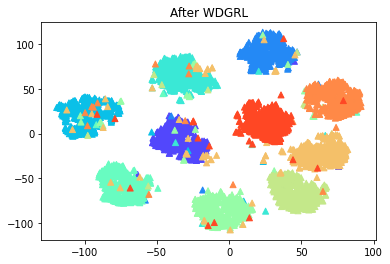

In [ ]:
plt.scatter(points[:,0],points[:,1], 
            marker='^', 
            c =data.source_train_label,
            cmap=ListedColormap(sns.color_palette('rainbow', n_colors=10).as_hex())
             )
plt.title("After WDGRL")
plt.savefig("./Results/tsne_after.png", bbox_inches = 'tight')

In [7]:
clsfr = models.CLFR(opt)
clsfr.load_state_dict(torch.load(opt.before_wdgrl))

<All keys matched successfully>

In [8]:
clsfr.cuda()

CLFR(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out

In [11]:
utils.set_requires_grad(clsfr, requires_grad=False)
features = clsfr.feature_extractor(data.target_train_subtom.cuda())

In [12]:
features = features.cpu().numpy()

In [13]:
tsne = TSNE(n_components=2, n_iter=5000, random_state=42)
points = tsne.fit_transform(features)

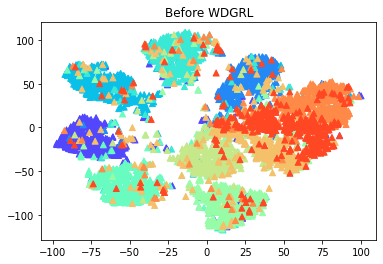

In [14]:
plt.scatter(points[:,0],points[:,1], 
            marker='^', 
            c =data.target_train_label,
            cmap=ListedColormap(sns.color_palette('rainbow', n_colors=10).as_hex())
             )

plt.title("Before WDGRL")
plt.savefig("./Results/tsne_before.png", bbox_inches = 'tight')